In [1]:
import numpy as np
import matplotlib.pyplot as plt
import QuantLib as ql
from datetime import datetime 
import pandas as pd
import attr
import math
import typing
import xlwings as xw
import time

In [71]:
@attr.s
class twoFactorHW:
    market_curve: ql.YieldTermStructure = attr.ib(default=ql.FlatForward(2, ql.TARGET(), 0.03, ql.Actual360()))
    today_date: ql.Date = attr.ib(default=ql.Date.from_date(datetime.today()))
    a: float = attr.ib(default=0.03)
    sigma: float = attr.ib(default=0.0042)
    b: float = attr.ib(default = 0.03)
    eta: float = attr.ib(default=0.0042)
    rho : float = attr.ib(default= 0.70)
        
    def phi(self, t: float) -> float:  # pagina 146 Brigo-Mercurio
        f = self.market_curve.forwardRate(t, t+0.002739726, ql.Continuous).rate() # t+ 1 giorno
        exp_at = 1- np.exp(-self.a*t)
        exp_bt = 1- np.exp(-self.b*t)
        phi_t = f + (self.sigma**2/(2*self.a**2)) * (exp_at**2) + (self.eta**2/(2*self.b**2)) * (exp_bt**2) + self.rho *(self.sigma*self.eta/(self.a*self.b))*exp_at*exp_bt
        return phi_t
    
    def x_t(self, t: float, s: float , x_s:float):
        E_xt = x_s * math.exp(-self.a*(t-s))
        var_xt = self.sigma**2 * (t-s)
        return np.random.normal(loc= E_xt, scale=math.sqrt(var_xt))
    def y_t(self, t:float, s:float, y_s:float):
        E_yt = y_s * math.exp(-self.b*(t-s))
        var_xt = self.eta**2 * (t-s)
        return np.random.normal(loc= E_yt, scale=math.sqrt(var_yt))

    def gauss_params(self, s: float, t: float, r_s: float, x_s: float, y_s:int ) -> typing.Tuple[float, float]:
        decay_factor_a = math.exp(-self.a*(t-s))
        decay_factor_b = math.exp(-self.b*(t-s))
        decay_factor_2a = math.exp(-2*self.a*(t-s))
        decay_factor_2b = math.exp(-2*self.b*(t-s))
        decay_factor_cross = math.exp(-(self.a + self.b)*(t-s))
        E_rt = x_s*decay_factor_a + y_s*decay_factor_b + self.phi(t)
        
        Var_rt = (self.sigma**2 / 2*self.a) * (1- decay_factor_2a) + (self.eta**2/2*self.b)*(1 - decay_factor_2b) 
        Var_rt += 2*self.rho*(self.sigma*self.eta/(self.a + self.b))*(1- decay_factor_cross)
        return E_rt, Var_rt
    
    def short_rate_path(self, path_length: float, 
                        path_steps: float,
                        times: np.array = None) -> typing.Tuple[np.array, np.array]:
        if times is None:
            times, dt = np.linspace(start=0.0, stop=path_length, num=path_steps, retstep=True)
        rt_path = np.zeros_like(times)
        x_ts = np.zeros_like(times)
        y_ts = np.zeros_like(times)
        rt_path[0] = self.market_curve.forwardRate(0, 0, ql.Continuous).rate()
        x_ts[0] = 0
        y_ts[0] = 0
        for step, tpl in enumerate(zip(times[:-1], times[1:]), 1):
            s, t = tpl
            x_s = x_ts[step-1]
            y_s = y_ts[step-1]
            Et, Vt = self.gauss_params(s, t, rt_path[step-1], x_s, y_s)
            rt = np.random.normal(loc=Et, scale=math.sqrt(Vt))
            x_ts[step] = self.x_t(t, s, x_s)
            rt_path[step] = rt
        return times, rt_path
    
    def short_rate_simul(self, path_length, path_steps, times: np.array = None):
        Nsimul = 1
        seed = 1
        if times is None:
            times, dt = np.linspace(start=0.0, stop=path_length, num=path_steps, retstep=True)
        m = len(times)
        r = np.zeros((Nsimul,m))
        x = np.zeros((Nsimul,m))
        y = np.zeros((Nsimul,m))
        for n in range(0,Nsimul):
            z1 = np.random.normal(0,1)
            z2 = np.random.normal(0,1)
            r[:,0] = self.market_curve.forwardRate(0, 0, ql.Continuous).rate()
            x[:,0] = 0
            y[:,0] = 0
            for step, tpl in enumerate(zip(times[:-1], times[1:]), 1):
                s, t = tpl
                x[n,step] = x[n,step -1] - self.a*dt + self.sigma*np.sqrt(dt)*z1
                y[n,step] = y[n,step -1] - self.b*dt + self.eta*self.rho*np.sqrt(dt)*z1 + self.eta*np.sqrt(1-self.rho**2)*z2
                r[n,step] = x[n,step] + y[n,step] + self.phi(t)
        return r

In [72]:
myhw = twoFactorHW(a=0.04, sigma = 0.0045, b = 0.02, eta = 0.0040, rho = 0.6)

In [73]:
short_rate = myhw.short_rate_simul(10, 25)

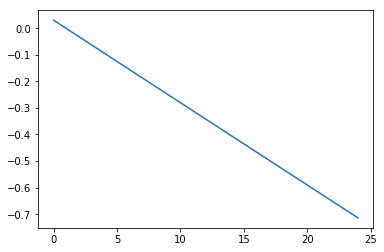

In [74]:
plt.plot(short_rate.T)
plt.show()

In [68]:
np.random.normal(0,1)

-0.656432733303092